In [47]:
import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np

import gym
import roboschool
import pybullet_envs

# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init, hidden_dims=[64, 64,]):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        i = state_dim
        layers = []
        for o in hidden_dims:
            layers += [
                torch.nn.Linear(i, o),
                torch.nn.Tanh(),
            ]
            i = o
        layers += [torch.nn.Linear(i, action_dim)]
        if has_continuous_action_space:
            layers += [nn.Tanh()]
        else:
            layers += [nn.Softmax(dim=-1)]
        self.actor = torch.nn.Sequential(*layers)

        # critic
        i = state_dim
        layers = []
        for o in hidden_dims:
            layers += [
                torch.nn.Linear(i, o),
                torch.nn.Tanh(),
            ]
            i = o
        layers += [torch.nn.Linear(i, 1),]
        self.critic = nn.Sequential(*layers)
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.detach(), action_logprob.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)

        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        
        
       



Device set to : Tesla V100-PCIE-32GB


################################################################################
> # **Part - II**

*   train PPO algorithm on environments
*   save preTrained networks weights and log files

################################################################################

In [48]:

print("============================================================================================")


from gym import spaces
class ReduceActionWrapper(gym.ActionWrapper):
    def __init__(self, env, action_map):
        super().__init__(env)
        self.action_map = action_map
        self.action_space = spaces.Discrete(len(action_map))

    def action(self, act): # modify action
        return self.action_map[act]

class ReduceObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, obs_idx):
        super().__init__(env)
        self.obs_idx = obs_idx
        self.observation_space = spaces.Box(-np.inf, np.inf, shape=(len(obs_idx),), dtype=np.float32)

    def observation(self, observation):
        return observation[self.obs_idx]
################################### Training ###################################


####### initialize environment hyperparameters ######

env_name = "LunarLander-v2"
reduce_dim = False
action_map = {0: 0, 1: 1, 2: 3, 3:2}
obs_idx = [0, 1, 3, 4, 5, 2, 6, 7]
print("training environment name : " + env_name)
env = gym.make(env_name)
if reduce_dim: 
    env_name += '_reduce'
else:
    env_name += 'Surgery'
env = ReduceActionWrapper(env, action_map=action_map)
env = ReduceObsWrapper(env, obs_idx)

has_continuous_action_space = False

max_ep_len = 300                    # max timesteps in one episode
max_training_timesteps = int(1e5)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(2e4)      # save model frequency (in num timesteps)

action_std = None

update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


training environment name : LunarLander-v2


In [49]:
log_dir = "PPO_logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)


#### create new log file for each run 
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)

run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)
if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


current logging run number for LunarLander-v2Surgery :  1
logging at : PPO_logs/LunarLander-v2Surgery//PPO_LunarLander-v2Surgery_log_1.csv
save checkpoint path : PPO_preTrained/LunarLander-v2Surgery/PPO_LunarLander-v2Surgery_0_0.pth


In [51]:
# preTrained weights directory
random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num
total_test_episodes = 10 
print("--------------------------------------------------------------------------------------------")
test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    ep_reward = 0
    state = env.reset()
    
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward
        
        if done:
            break

    # clear buffer    
    ppo_agent.buffer.clear()

    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0

env.close()

print("============================================================================================")

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")


--------------------------------------------------------------------------------------------
Episode: 1 		 Reward: -38.99
Episode: 2 		 Reward: -347.1
Episode: 3 		 Reward: -58.92
Episode: 4 		 Reward: -209.93
Episode: 5 		 Reward: -101.79
Episode: 6 		 Reward: -271.99
Episode: 7 		 Reward: -116.25
Episode: 8 		 Reward: -325.97
Episode: 9 		 Reward: -372.49
Episode: 10 		 Reward: -486.13
average test reward : -232.96


In [52]:
directory = "PPO_preTrained" + '/' + 'LunarLander-v2_reduce' + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format('LunarLander-v2_reduce', random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)
old_ppo_agent = PPO(5, 3, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
old_ppo_agent.load(checkpoint_path)

loading network from : PPO_preTrained/LunarLander-v2_reduce/PPO_LunarLander-v2_reduce_0_0.pth


In [68]:
# before Surgery
ppo_agent.policy_old.actor[4].weight,ppo_agent.policy_old.actor[4].bias

(Parameter containing:
 tensor([[ 6.5704e-02,  9.6717e-02, -5.7153e-02,  9.6731e-02,  2.9199e-02,
           5.2487e-02, -1.2366e-01, -8.6024e-02,  7.1024e-02,  1.0878e-01,
           2.6586e-02,  6.5506e-02, -2.5891e-02,  1.1521e-01, -8.3649e-02,
          -1.2401e-01,  1.1849e-01, -1.4202e-02,  6.0800e-02, -1.4078e-02,
          -8.2573e-02, -5.2079e-03,  1.2290e-01, -1.1417e-01, -4.0142e-02,
          -3.7374e-02, -5.6233e-02,  5.3300e-02, -1.1327e-01, -1.0230e-01,
          -3.8826e-03, -8.2033e-02,  8.6387e-02, -9.7374e-02,  9.5296e-02,
          -2.6663e-02,  3.1430e-02,  8.1917e-02,  1.0382e-01, -6.9855e-02,
           5.1908e-02, -1.3670e-02,  8.4252e-02,  9.6023e-02, -3.9999e-02,
           1.1915e-01, -7.3052e-02,  5.1248e-02, -1.0442e-01, -5.2604e-02,
          -3.5847e-02,  2.9034e-02,  4.1508e-02,  1.1084e-01,  1.0576e-01,
           7.7092e-02, -3.9658e-02, -8.6893e-02,  1.0703e-02,  3.8647e-03,
          -1.5696e-02,  8.2125e-02, -2.7150e-02,  9.9706e-03],
         [-9.0

In [41]:
# Surgery on input and output (state and action)
################################ End of Part II ################################
# new_layer_n = [6, 7] # 说明新模型第几层是新的, 从0开始.
def get_liner_name(net):
    name_list = []
    for name, g in list(net.named_modules())[1:]:
        if isinstance(g, nn.Linear):
            name_list.append(name)
    return name_list

def get_conv_name(net):
    name_list = []
    for name, g in list(net.named_modules())[1:]:
        if isinstance(g, nn.Conv2d):
            name_list.append(name)
    return name_list

def Surgery_move(new_w, new_b, old_w, old_b, eps=0):
    old_outdim, old_indim = old_w.shape
    new_w[:old_outdim, :old_indim] = old_w
    new_w[:old_outdim, old_indim:] *= eps
    # new_w[old_outdim:, ]
    # new_b[old_outdim:] *= 0
    new_b[:old_outdim] = old_b
    return new_w, new_b

def Surgery2(oldnet, newnet, new_layer_n=[]):
    # call after surgery conv
    old_name = get_liner_name(oldnet)
    new_name = get_liner_name(newnet)
    old_p = oldnet.state_dict()
    new_p = newnet.state_dict()
    id_index = 0 # record how much identity
    out = -1 # TODO: input feature dim 
    for i, layer in enumerate(new_name):
        new_w, new_b = new_p[layer+'.weight'], new_p[layer+'.bias']
        if i in new_layer_n: # identity 
            old_w, old_b = torch.eye(out, out), torch.zeros([out])
            id_index += 1
        else:
            name = old_name[i - id_index]
            old_w, old_b = old_p[name+'.weight'], old_p[name+'.bias']
        new_w, new_b = Surgery_move(new_w, new_b, old_w, old_b)
        out = old_b.shape[0]
    return new_p


newp = Surgery2(old_ppo_agent.policy_old, ppo_agent.policy_old)
ppo_agent.policy.load_state_dict(ppo_agent.policy_old.state_dict())

<All keys matched successfully>

In [42]:
# after Surgery
ppo_agent.policy_old.state_dict()

OrderedDict([('actor.0.weight',
              tensor([[-0.0559, -0.3249,  0.2411,  0.0258,  0.2218,  0.0000,  0.0000,  0.0000],
                      [ 0.2176,  0.1396,  0.0221, -0.3823,  0.2915, -0.0000, -0.0000, -0.0000],
                      [ 0.0913, -0.1530, -0.0075, -0.0135,  0.2839,  0.0000,  0.0000,  0.0000],
                      [ 0.0920,  0.0744, -0.1468, -0.0575,  0.3018,  0.0000, -0.0000, -0.0000],
                      [ 0.3267,  0.2497, -0.1614,  0.3208,  0.1807,  0.0000, -0.0000, -0.0000],
                      [-0.4453,  0.1002, -0.0434, -0.2276, -0.2555,  0.0000, -0.0000, -0.0000],
                      [-0.0306, -0.0720,  0.0689, -0.6184, -0.3987, -0.0000, -0.0000, -0.0000],
                      [ 0.1161, -0.0945,  0.1447, -0.0473, -0.5246,  0.0000, -0.0000,  0.0000],
                      [-0.2226,  0.1050,  0.0692,  0.1959, -0.1479,  0.0000, -0.0000,  0.0000],
                      [ 0.2807,  0.0942, -0.4152, -0.1220,  0.5275,  0.0000,  0.0000,  0.0000],
        

In [43]:
total_test_episodes

10

In [44]:
# preTrained weights directory
random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num
print("--------------------------------------------------------------------------------------------")
test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    ep_reward = 0
    state = env.reset()
    
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward
        
        if done:
            break

    # clear buffer    
    ppo_agent.buffer.clear()

    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0

env.close()
print("============================================================================================")

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")


--------------------------------------------------------------------------------------------
Episode: 1 		 Reward: -77.34
Episode: 2 		 Reward: -116.25
Episode: 3 		 Reward: -83.88
Episode: 4 		 Reward: -81.67
Episode: 5 		 Reward: -155.47
Episode: 6 		 Reward: -53.83
Episode: 7 		 Reward: -74.49
Episode: 8 		 Reward: -93.63
Episode: 9 		 Reward: -74.11
Episode: 10 		 Reward: -55.99
average test reward : -86.66


In [45]:
max_training_timesteps

100000

In [13]:

# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0


# training loop
while time_step <= max_training_timesteps:
    
    state = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()
            
        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0
            
        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")
            
        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


log_f.close()
env.close()




# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")




Started training at (GMT) :  2022-05-31 07:48:39
Episode : 17 		 Timestep : 1600 		 Average Reward : -87.23
Episode : 34 		 Timestep : 3200 		 Average Reward : -84.97
Episode : 51 		 Timestep : 4800 		 Average Reward : -67.19
Episode : 67 		 Timestep : 6400 		 Average Reward : -78.32
Episode : 83 		 Timestep : 8000 		 Average Reward : -59.6
Episode : 98 		 Timestep : 9600 		 Average Reward : -48.89
Episode : 111 		 Timestep : 11200 		 Average Reward : -57.09
Episode : 121 		 Timestep : 12800 		 Average Reward : -62.47
Episode : 128 		 Timestep : 14400 		 Average Reward : -32.43
Episode : 137 		 Timestep : 16000 		 Average Reward : -42.36
Episode : 144 		 Timestep : 17600 		 Average Reward : -13.32
Episode : 149 		 Timestep : 19200 		 Average Reward : 35.36
--------------------------------------------------------------------------------------------
saving model at : PPO_preTrained/LunarLander-v2_reduce/PPO_LunarLander-v2_reduce_0_0.pth
model saved
Elapsed Time  :  0:02:46
--------------

In [16]:
print("============================================================================================")
#################################### Testing ###################################

################## hyperparameters ##################

env_name = "LunarLander-v2"
has_continuous_action_space = False
max_ep_len = 300
action_std = None
total_test_episodes = 10    # total num of testing episodes

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003           # learning rate for actor
lr_critic = 0.001           # learning rate for critic

#####################################################


env = gym.make(env_name)
reduce_dim = False
if reduce_dim: 
    env_name += '_reduce'
else:
    env_name += 'Surgery'
env = ReduceActionWrapper(env, action_map=action_map)
env = ReduceObsWrapper(env, obs_idx)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    ep_reward = 0
    state = env.reset()
    
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward
        
        if done:
            break

    # clear buffer    
    ppo_agent.buffer.clear()

    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0

env.close()


print("============================================================================================")

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")


loading network from : PPO_preTrained/LunarLander-v2Surgery/PPO_LunarLander-v2Surgery_0_0.pth
--------------------------------------------------------------------------------------------
Episode: 1 		 Reward: 132.37
Episode: 2 		 Reward: 182.83
Episode: 3 		 Reward: 138.04
Episode: 4 		 Reward: -19.62
Episode: 5 		 Reward: 189.28
Episode: 6 		 Reward: 145.87
Episode: 7 		 Reward: 156.2
Episode: 8 		 Reward: 49.42
Episode: 9 		 Reward: 56.02
Episode: 10 		 Reward: 134.64
average test reward : 116.51


'\nloading network from : PPO_preTrained/LunarLander-v2_reduce/PPO_LunarLander-v2_reduce_0_0.pth\n--------------------------------------------------------------------------------------------\nEpisode: 1 \t\t Reward: -95.45\nEpisode: 2 \t\t Reward: -85.54\nEpisode: 3 \t\t Reward: -129.2\nEpisode: 4 \t\t Reward: -100.1\nEpisode: 5 \t\t Reward: -88.29\nEpisode: 6 \t\t Reward: -95.57\nEpisode: 7 \t\t Reward: -119.63\nEpisode: 8 \t\t Reward: -97.12\nEpisode: 9 \t\t Reward: -120.03\nEpisode: 10 \t\t Reward: -99.4\n============================================================================================\naverage test reward : -103.03\n============================================================================================\n\n'

################################################################################
> # **Part - IV**

*   load log files using pandas
*   plot graph using matplotlib

################################################################################

loading data from : PPO_logs/LunarLander-v2Surgery/PPO_LunarLander-v2Surgery_log_0.csv
data shape :  (125, 3)
--------------------------------------------------------------------------------------------
figure saved at :  PPO_figs/LunarLander-v2Surgery//PPO_LunarLander-v2Surgery_fig_0.png


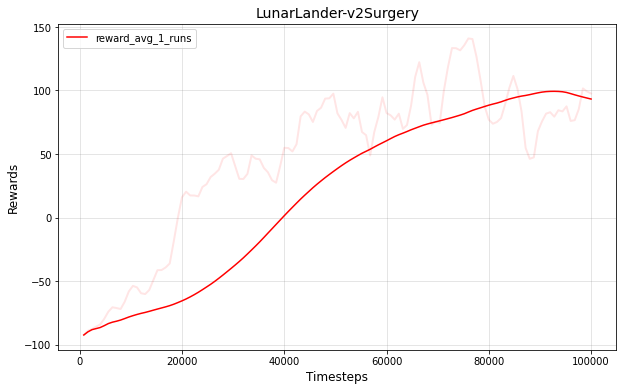

In [46]:

import os
import pandas as pd
import matplotlib.pyplot as plt


print("============================================================================================")

env_name = 'LunarLander-v2Surgery'


fig_num = 0     #### change this to prevent overwriting figures in same env_name folder

plot_avg = True    # plot average of all runs; else plot all runs separately

fig_width = 10
fig_height = 6


# smooth out rewards to get a smooth and a less smooth (var) plot lines
window_len_smooth = 50
min_window_len_smooth = 1
linewidth_smooth = 1.5
alpha_smooth = 1

window_len_var = 5
min_window_len_var = 1
linewidth_var = 2
alpha_var = 0.1


colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson','gray', 'black']


# make directory for saving figures
figures_dir = "PPO_figs"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# make environment directory for saving figures
figures_dir = figures_dir + '/' + env_name + '/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)


fig_save_path = figures_dir + '/PPO_' + env_name + '_fig_' + str(fig_num) + '.png'


# get number of log files in directory
log_dir = "PPO_logs" + '/' + env_name#  + '/'

# current_num_files = next(os.walk(log_dir))[2]
# num_runs = len(current_num_files)
num_runs = 1

all_runs = []

for run_num in range(num_runs):

    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
    print("loading data from : " + log_f_name)
    data = pd.read_csv(log_f_name)
    data = pd.DataFrame(data)
    
    print("data shape : ", data.shape)
    
    all_runs.append(data)
    print("--------------------------------------------------------------------------------------------")


ax = plt.gca()

if plot_avg:
    # average all runs
    df_concat = pd.concat(all_runs)
    df_concat_groupby = df_concat.groupby(df_concat.index)
    data_avg = df_concat_groupby.mean()

    # smooth out rewards to get a smooth and a less smooth (var) plot lines
    data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
    data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

    data_avg.plot(kind='line', x='timestep' , y='reward_smooth',ax=ax,color=colors[0],  linewidth=linewidth_smooth, alpha=alpha_smooth)
    data_avg.plot(kind='line', x='timestep' , y='reward_var',ax=ax,color=colors[0],  linewidth=linewidth_var, alpha=alpha_var)

    # keep only reward_smooth in the legend and rename it
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[0]], ["reward_avg_" + str(len(all_runs)) + "_runs"], loc=2)


else:
    for i, run in enumerate(all_runs):
        # smooth out rewards to get a smooth and a less smooth (var) plot lines
        run['reward_smooth_' + str(i)] = run['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        run['reward_var_' + str(i)] = run['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()
        
        # plot the lines
        run.plot(kind='line', x='timestep' , y='reward_smooth_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_smooth, alpha=alpha_smooth)
        run.plot(kind='line', x='timestep' , y='reward_var_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_var, alpha=alpha_var)

    # keep alternate elements (reward_smooth_i) in the legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for i in range(len(handles)):
        if(i%2 == 0):
            new_handles.append(handles[i])
            new_labels.append(labels[i])
    ax.legend(new_handles, new_labels, loc=2)



# ax.set_yticks(np.arange(0, 1800, 200))
# ax.set_xticks(np.arange(0, int(4e6), int(5e5)))


ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Rewards", fontsize=12)

plt.title(env_name, fontsize=14)

fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)

print("============================================================================================")

plt.savefig(fig_save_path)
print("figure saved at : ", fig_save_path)

print("============================================================================================")


plt.show()




In [ ]:



################################ End of Part IV ################################




################################################################################
> # **Part - V**

*   install virtual display libraries for rendering on colab / remote server ^
*   load preTrained networks and save images for gif
*   generate and save gif from previously saved images

*   ^ If running locally; do not install xvbf and pyvirtualdisplay. Just comment out the virtual display code and render it normally. 
*   ^ You will still require to use ipythondisplay, if you want to render it in the Jupyter Notebook.

################################################################################

In [18]:


#### to render on colab / server / headless machine install virtual display libraries

!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1



In [20]:


############################# save images for gif ##############################


import os
import glob

import gym
import roboschool
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


from IPython import display as ipythondisplay

from pyvirtualdisplay import Display



"""
One frame corresponding to each timestep is saved in a folder :

PPO_gif_images/env_name/000001.jpg
PPO_gif_images/env_name/000002.jpg
PPO_gif_images/env_name/000003.jpg
...
...
...


if this section is run multiple times or for multiple episodes for the same env_name; 
then the saved images will be overwritten.

"""




#### beginning of virtual display code section

display = Display(visible=0, size=(400, 300))
display.start()

#### end of virtual display code section



print("============================================================================================")


################## hyperparameters ##################

env_name = 'LunarLander-v2'
has_continuous_action_space = False
max_ep_len = 400
action_std = None


# env_name = "LunarLander-v2"
# has_continuous_action_space = False
# max_ep_len = 300
# action_std = None

# env_name = "BipedalWalker-v2"
# has_continuous_action_space = True
# max_ep_len = 1500           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving

# env_name = "RoboschoolWalker2d-v1"
# has_continuous_action_space = True
# max_ep_len = 1000           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


total_test_episodes = 1     # save gif for only one episode

render_ipython = False      # plot the images using matplotlib and ipythondisplay before saving (slow)

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003         # learning rate for actor
lr_critic = 0.001         # learning rate for critic

#####################################################


env = gym.make(env_name)
env = ReduceActionWrapper(env, action_map)
env = ReduceObsWrapper(env, obs_idx)
env_name += '_reduce'

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n



# make directory for saving gif images
gif_images_dir = "PPO_gif_images" + '/'
if not os.path.exists(gif_images_dir):
    os.makedirs(gif_images_dir)

# make environment directory for saving gif images
gif_images_dir = gif_images_dir + '/' + env_name + '/'
if not os.path.exists(gif_images_dir):
    os.makedirs(gif_images_dir)

# make directory for gif
gif_dir = "PPO_gifs" + '/'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

# make environment directory for gif
gif_dir = gif_dir + '/' + env_name  + '/'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    
    ep_reward = 0
    state = env.reset()

    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward

        img = env.render(mode = 'rgb_array')


        #### beginning of ipythondisplay code section 1

        if render_ipython:
            plt.imshow(img)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

        #### end of ipythondisplay code section 1


        img = Image.fromarray(img)
        img.save(gif_images_dir + '/' + str(t).zfill(6) + '.jpg')
        
        if done:
            break
    
    # clear buffer    
    ppo_agent.buffer.clear()
    
    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0



env.close()


#### beginning of ipythondisplay code section 2

if render_ipython:
    ipythondisplay.clear_output(wait=True)

#### end of ipythondisplay code section 2




print("============================================================================================")

print("total number of frames / timesteps / images saved : ", t)

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")







loading network from : PPO_preTrained/LunarLander-v2_reduce/PPO_LunarLander-v2_reduce_0_0.pth
--------------------------------------------------------------------------------------------


ImportError: 
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    

In [21]:



######################## generate gif from saved images ########################


print("============================================================================================")


env_name = 'LunarLander-v2'
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


gif_num = 0     #### change this to prevent overwriting gifs in same env_name folder

# adjust following parameters to get desired duration, size (bytes) and smoothness of gif
total_timesteps = 300
step = 10
frame_duration = 150


# input images
gif_images_dir = "PPO_gif_images/" + env_name + '/*.jpg'


# ouput gif path
gif_dir = "PPO_gifs"
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

gif_dir = gif_dir + '/' + env_name
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

gif_path = gif_dir + '/PPO_' + env_name + '_gif_' + str(gif_num) + '.gif'

img_paths = sorted(glob.glob(gif_images_dir))
img_paths = img_paths[:total_timesteps]
img_paths = img_paths[::step]


print("total frames in gif : ", len(img_paths))
print("total duration of gif : " + str(round(len(img_paths) * frame_duration / 1000, 2)) + " seconds")

# save gif
img, *imgs = [Image.open(f) for f in img_paths]
img.save(fp=gif_path, format='GIF', append_images=imgs, save_all=True, optimize=True, duration=frame_duration, loop=0)

print("saved gif at : ", gif_path)



print("============================================================================================")


total frames in gif :  0
total duration of gif : 0.0 seconds


ValueError: not enough values to unpack (expected at least 1, got 0)

In [ ]:

############################# check gif byte size ##############################


import os
import glob


print("============================================================================================")

env_name = 'CartPole-v1'
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


gif_dir = "PPO_gifs/" + env_name + '/*.gif'

gif_paths = sorted(glob.glob(gif_dir))

for gif_path in gif_paths:
    file_size = os.path.getsize(gif_path)
    print(gif_path + '\t\t' + str(round(file_size / (1024 * 1024), 2)) + " MB")


print("============================================================================================")





In [ ]:



################################# End of Part V ################################




################################################################################

---------------------------------------------------------------------------- That's all folks ! ----------------------------------------------------------------------------


################################################################################